In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append(os.path.abspath('../src/'))
from ModelSelection import *
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

In [2]:
cup_df = pd.read_csv(
    '../data/ML-CUP23-TR.csv',
    index_col=0,
    comment='#',
    header=None,
    names=['feature_' + str(i+1) for i in range(10)] + ['target_' + str(i+1) for i in range(3)]
)

data_set = cup_df.values
len_data = len(data_set)
np.random.shuffle(data_set)

training_len = int(0.8*len_data)

training_set = data_set[:int(training_len)] # Training Set for KFold Cross Validation
test_set = data_set[int(training_len):] # Hold Out Test Set

TR_OUTPUT = 3
TR_INPUT = data_set.shape[1] - TR_OUTPUT

scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(training_set[:,:TR_INPUT])
scaler_out.fit(training_set[:,TR_INPUT:])

tr_normalized = np.empty((training_len, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(training_set[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(training_set[:,TR_INPUT:])

test_normalized = np.empty((len_data - training_len, TR_OUTPUT + TR_INPUT))
test_normalized[:,:TR_INPUT] = scaler_in.transform(test_set[:,:TR_INPUT])
test_normalized[:,TR_INPUT:] = scaler_out.transform(test_set[:,TR_INPUT:])

In [3]:
hidden_len = 40
hidden_fun = 'sigmoid'
output_fun = 'identity'

sigmoid_l1_big = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)


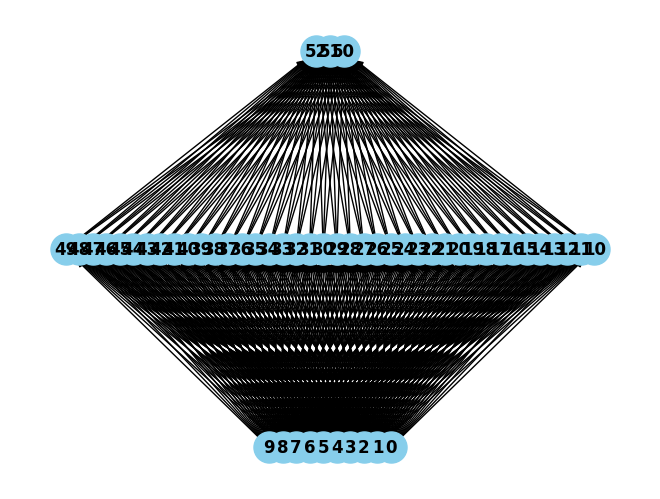

In [4]:
NeuralNetwork.display_topology(sigmoid_l1_big)

In [5]:
MS = ModelSelection('../data/gs_data/1l_sigmoid_2_big.csv')
MS.default_values['metrics'] = [ErrorFunctions.mean_euclidean_error, ErrorFunctions.mean_squared_error]
hyperparam_grid = {
    'learning_rate':[0.01, 0.1, 0.2],
    'lr_decay_tau':[250],
    'adamax' : [True, False],
    'adamax_learning_rate' : [0.01, 0.05, 0.03, 0.07],
    'exp_decay_rate_1':[0.9, 0.95],
    'exp_decay_rate_2':[0.999],
    'alpha_momentum':[0.1, 0.5, 0.9],
    'lambda_tikhonov':[0.00001, 0.0001],
    'batch_size':[int(training_len/20), int(training_len/40)],
    'min_epochs': [100],
    'max_epochs':[600],
    'error_increase_tolerance':[0.00001],
    'patience':[8],
    'topology': [str(sigmoid_l1_big)],
}

c1 = lambda x: x
constr = {'adamax': (c1, ['learning_rate', 'alpha_momentum', 'lr_decay_tau'], ['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2'])}
MS.grid_searchKF(tr_normalized, hyperparam_grid,  3, 12, False, constr)

Already done:  0
tot conf: 68
removed already done conf: 68
tot conf: 68


KeyboardInterrupt: 